In [2]:
import pandas as pd
from collections import Counter
import numpy as np
import math
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
%matplotlib inline
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justinchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
df = pd.read_csv('/Users/justinchen/Desktop/AARD Datasets/mental_health_subreddits_dataset.csv')

In [18]:
df.dropna(axis = 0, how = 'any')

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
0,963,covid19_support,1635203992,This. Plus remember the poster in here a few w...,-0.6652
1,967,anxiety,1635203988,Currently 8 and a half months pregnant and als...,-0.8555
2,1142,anxiety,1635203613,Few people had COVID in my building and refuse...,-0.2960
3,1403,covid19_support,1635202948,My friend will be so relieved she didn't actua...,0.7626
4,1616,depression,1635202459,This hits close to home. \n\nHe sounds similar...,-0.4006
...,...,...,...,...,...
45879,17777050,anxiety,1581473713,"It is quite interesting, in terms of somewhat ...",-0.9256
45880,17777094,anxiety,1581466598,Stay focused on what the experts are saying an...,0.7430
45881,17777113,anxiety,1581463547,"No new COVID-19 cases in B.C., 4 confirmed pat...",-0.1531
45882,17777197,mentalhealth,1581454025,"Hi mate, as someone with GAD I can relate to y...",0.5332


In [19]:
sample = df.sample(45000)
sample.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
22325,10824504,covid19_support,1605423276,"Well, unfortunately we had no clue he had COVI...",-0.5552
38330,15606028,covid19_support,1590594124,"Honestly, I don't know. One of my favorite hob...",0.8912
32929,14147933,covid19_support,1595407494,I had to deal with a repair also and I was rea...,0.9071
279,152476,covid19_support,1634749119,You aren't alone. \n\nI'm unable to get vaccin...,-0.4684
37393,15355876,covid19_support,1591547858,My parents are very clear about the risks impo...,0.1348


In [6]:
count = Counter()
for index, row in sample.iterrows():
    if row['subreddit.name'] == 'anxiety':
        count['anxiety'] += 1
    if row['subreddit.name'] == 'depression':
        count['depression'] += 1
    if row['subreddit.name'] == 'suicidewatch':
        count['SuicideWatch'] += 1
    if row['subreddit.name'] == 'mentalhealth':
        count['mentalhealth'] += 1
    if row['subreddit.name'] == 'covid19_support':
        count['COVID19_support'] += 1
count

Counter({'depression': 5770,
         'anxiety': 16363,
         'COVID19_support': 15650,
         'SuicideWatch': 3970,
         'mentalhealth': 3247})

## Preprocessing 

In [7]:
import re #regex library used for substituting words
import demoji #https://github.com/bsolomon1124/demoji
# demoji.download_codes()

In [8]:
def pre_cleaning(text):
    line=re.sub(r"\Bu/\w+", "USERNAME", text) #replace username with USERNAME
    line = demoji.replace(line, repl=' ')
    return line

In [9]:
#removing stopwords and urls, stemming, making lowercase 
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def cleaning(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [10]:
def post_cleaning(text):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ',text)

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    
    #remove digits
    processed_feature = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", processed_feature)

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    return processed_feature

In [11]:
#above functions combined
def preprocessing(text):
    line = pre_cleaning(text)
    line = cleaning(line)
    line = post_cleaning (line)
    return line

In [23]:
sample.body = sample.body.apply(lambda x: preprocessing(x))

In [24]:
sample.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
22325,10824504,covid19_support,1605423276,well unfortunately clue covid days exposure fo...,negative
38330,15606028,covid19_support,1590594124,honestly know one favorite hobbies bringing lo...,positive
32929,14147933,covid19_support,1595407494,deal repair also really afraid talk landlord h...,positive
279,152476,covid19_support,1634749119,alone unable get vaccinated covid really bad b...,negative
37393,15355876,covid19_support,1591547858,parents clear risks imposed covid light risks ...,positive


In [25]:
for sentiment in sample['sentiment']:
    if sentiment > 0:
        sample['sentiment'].replace({sentiment : 'positive'}, inplace=True)
    if sentiment < 0:
        sample['sentiment'].replace({sentiment : 'negative'}, inplace=True)
    else:
        sample['sentiment'].replace({sentiment : 'neutral'}, inplace=True)

TypeError: '>' not supported between instances of 'str' and 'int'

Text(0.5, 1.0, 'Sentiment Data Distribution')

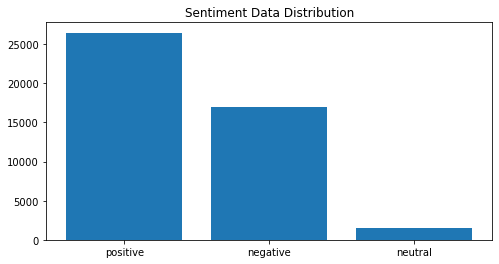

In [26]:
#Graphing
val_count = sample.sentiment.value_counts()
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [27]:
sample.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
22325,10824504,covid19_support,1605423276,well unfortunately clue covid days exposure fo...,negative
38330,15606028,covid19_support,1590594124,honestly know one favorite hobbies bringing lo...,positive
32929,14147933,covid19_support,1595407494,deal repair also really afraid talk landlord h...,positive
279,152476,covid19_support,1634749119,alone unable get vaccinated covid really bad b...,negative
37393,15355876,covid19_support,1591547858,parents clear risks imposed covid light risks ...,positive


In [28]:
from sklearn.model_selection import train_test_split

In [29]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(sample, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 36000
Test Data size 9000


## Vectorizing

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
vectorizer = TfidfVectorizer(max_features=14000,
                             min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
vectorizer.fit(train_data.body.to_list())
x_train = vectorizer.transform(train_data.body.to_list())
x_test = vectorizer.transform(test_data.body.to_list())

In [32]:
print("x_train Shape:",x_train.shape)
print("x_test Shape:",x_test.shape)

x_train Shape: (36000, 13098)
x_test Shape: (9000, 13098)


In [33]:
from sklearn.preprocessing import LabelEncoder

In [34]:
encoder = LabelEncoder() #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (36000, 1)
y_test shape: (9000, 1)


## Linear SVM Model

In [35]:
import time
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn import metrics

In [36]:
# Perform classification with SVM, kernel=linear
classifier_linear = svm.SVC(kernel='linear')
t0 = time.time()
classifier_linear.fit(x_train, y_train.ravel())
t1 = time.time()
prediction_linear = classifier_linear.predict(x_test)
t2 = time.time()
time_linear_train = t1-t0
time_linear_predict = t2-t1

labels = [0.0, 1.0, 2.0]
target_names = ['negative', 'neutral', 'positive']

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))

report = classification_report(y_test, prediction_linear, labels = labels, target_names = target_names, output_dict=True)

print("Accuracy:", metrics.accuracy_score(y_test, prediction_linear))

print('positive: ', report['positive'])
print('negative: ', report['negative'])
print('neutral: ', report['neutral'])

Training time: 578.694174s; Prediction time: 61.007645s
Accuracy: 0.8216666666666667
positive:  {'precision': 0.8506493506493507, 'recall': 0.8816601233875491, 'f1-score': 0.8658771688240154, 'support': 5349}
negative:  {'precision': 0.7775097980102502, 'recall': 0.7740096038415366, 'f1-score': 0.7757557527447736, 'support': 3332}
neutral:  {'precision': 0.7194244604316546, 'recall': 0.31347962382445144, 'f1-score': 0.43668122270742354, 'support': 319}


## Feature Importance

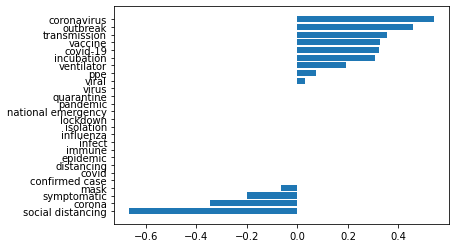

In [37]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = ['corona', 
                  'virus', 
                  'viral', 
                  'covid', 
                  'influenza', 
                  'pandemic', 
                  'epidemic', 
                  'quarantine', 
                  'lockdown',
                  'distancing', 
                  'national emergency',  
                  'infect', 
                  'ventilator', 
                  'mask', 
                  'symptomatic', 
                  'immune', 
                  'incubation', 
                  'transmission', 
                  'vaccine',
                  'confirmed case',
                  'coronavirus',
                  'covid-19',
                  'outbreak',
                  'ppe',
                  'isolation',
                  'social distancing' ]
f_importances(classifier_linear.coef_.toarray()[0], features_names)

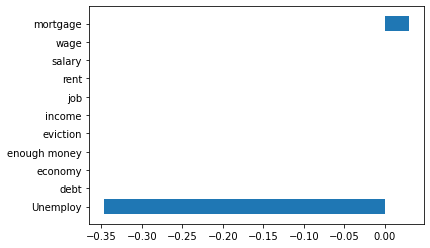

In [38]:
economy_features = ['Unemploy',
                    'rent',
                    'mortgage',
                         'economy',
                         'enough money',
                         'debt',
                         'salary', 
                          'wage', 
                          'income', 
                          'job', 
                          'eviction',
                         ]
f_importances(classifier_linear.coef_.toarray()[0], economy_features)

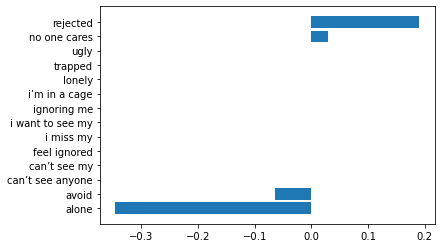

In [45]:
isolation_features = ['alone', 'lonely', 'no one cares', 'can’t see anyone', 'can’t see my', 'i miss my', 'i want to see my', 'trapped', 'i’m in a cage', 'feel ignored', 'ignoring me', 'ugly',
'rejected', 'avoid']
f_importances(classifier_linear.coef_.toarray()[0], isolation_features)

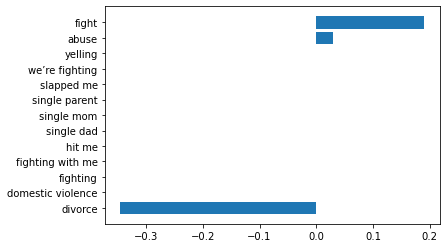

In [40]:
domestic_stress_features = ['divorce', 'domestic violence', 'abuse', 'yelling', 'fighting with me', 'we’re fighting', 'single mom',
'single dad', 'single parent', 'hit me', 'slapped me', 'fighting', 'fight']
f_importances(classifier_linear.coef_.toarray()[0], domestic_stress_features)

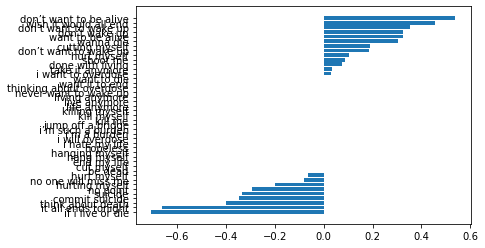

In [44]:
suicidality_features = ['commit suicide', 'jump off a bridge', 'i want to overdose', 'i’m a burden', 'i’m such a burden', 'i will overdose', 'thinking about overdose', 'kill myself', 'killing myself', 'hang myself', 
                        'hanging myself', 'cut myself', 'cutting myself', 'hurt myself', 'hurting myself', 'want to die', 'wanna die',
'don’t want to wake up', 'don’t wake up', 'never want to wake up', 'don’t want to be alive', 'want to be alive', 'wish it would all end', 'done with living', 'want it to end', 'it all ends tonight', 
                        'live anymore', 'living anymore', 'life anymore', 'be dead', 'take it anymore', 'end my life', 
                        'think about death', 'hopeless', 'hurt myself', 'no one will miss me', 'don’t want to wake up', 'if i live or die', 
                        'i hate my life', 'shoot me', 'kill me', 'suicide', 'no point']
f_importances(classifier_linear.coef_.toarray()[0], suicidality_features)

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC

37907


/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


IndexError: index 39175 is out of bounds for axis 0 with size 37907

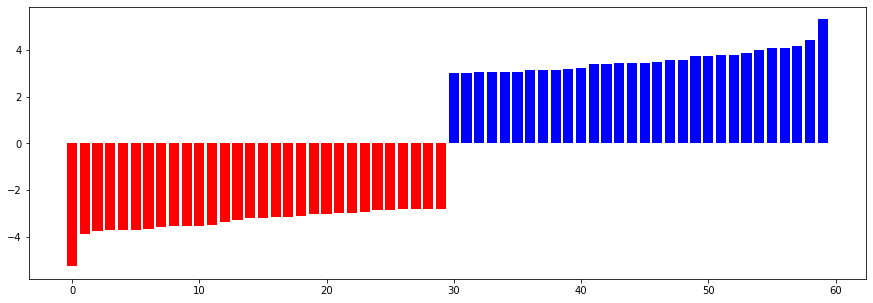

In [42]:
def plot_coefficients(classifier, feature_names, top_features=30):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    
cv = CountVectorizer(stop_words = 'english')
cv.fit(train_data.body.to_list())
print (len(cv.vocabulary_))

svm = LinearSVC()
svm.fit(x_train, y_train)

plot_coefficients(svm, cv.get_feature_names())